In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/NLP/Dacon_NH competition/data')

In [4]:
data_train = pd.read_csv('news_train.csv')
data_test = pd.read_csv('news_test.csv')

In [5]:
data_train.shape

(118745, 6)

In [6]:
data_test.shape

(142565, 6)

In [7]:
data_train.head()    

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


In [8]:
data_test.head()

,n_id,date,title,content,ord,id
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5


1. n_id와 ord 결합 -> id
2. date, title 필요?
3. info는 Y

In [9]:
# 불필요 열 삭제
del data_train['date']
del data_train['ord']


del data_test['date']
del data_test['ord']


data_train[:5]

,n_id,title,content,info
0,NEWS02580,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,0
1,NEWS02580,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",1
2,NEWS02580,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",1
3,NEWS02580,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,0
4,NEWS09727,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,0


In [10]:
data_test[:5]

,n_id,title,content,id
0,NEWS00237,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',NEWS00237_1
1,NEWS00237,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,NEWS00237_2
2,NEWS00237,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,NEWS00237_3
3,NEWS00237,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,NEWS00237_4
4,NEWS00237,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",NEWS00237_5


In [11]:
# Null값 확인
data_train.info()
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118745 entries, 0 to 118744
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   n_id     118745 non-null  object
 1   title    118745 non-null  object
 2   content  118745 non-null  object
 3   info     118745 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142565 entries, 0 to 142564
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   n_id     142565 non-null  object
 1   title    142565 non-null  object
 2   content  142565 non-null  object
 3   id       142565 non-null  object
dtypes: object(4)
memory usage: 4.4+ MB


In [12]:
# unique 를 통해 중복되는 값 삭제 -> (먼저 duplicates로 중복값 있는지 확인!) drop_duplicates() 사용 
# data_train['title'].unique(), data_train['content'].unique(), data_train['info'].unique, data_train['n_id'] 
# data_test['title'].unique(), data_test['content'].unique(), data_test['n_id']

# np.sum(data_train.duplicated(['content']))
# np.sum(data_train.duplicated(['content', 'info']))
np.sum(data_test.duplicated(['content']))

76738

In [44]:
set(data_train[data_train.duplicated(['content'])].index) - set(data_train[data_train.duplicated(['content', 'info'])].index)

{43736, 50772, 50774}

In [14]:
data_train.drop_duplicates(['content'], inplace=True)
data_train.shape

(46161, 4)

In [15]:
data_test.drop_duplicates(['content'], inplace=True)
data_test.shape

(65827, 4)

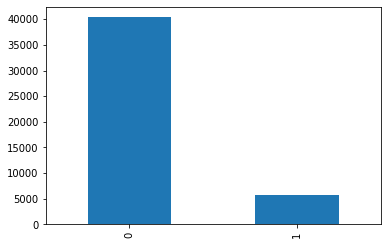

In [16]:
data_train['info'].value_counts().plot(kind='bar');

In [17]:
# 1(가짜뉴스) 데이터와 0(일반) 데이터 count 함수로 파악  
print(data_train.groupby('info').size().reset_index(name='count'))

   info  count
0     0  40370
1     1   5791


In [18]:
# 메일 본문과 레이블의 개수 파악
Train_x_data=data_train['content']
Train_y_data=data_train['info']

Test_x_data=data_test['content']
print('메일 본문의 개수:{}'.format(len(Train_x_data)))
print('레이블의 개수:{}'.format(len(Train_y_data)))

메일 본문의 개수:46161
레이블의 개수:46161


In [19]:
Train_y_data

0         0
1         1
2         1
3         0
4         0
         ..
118614    0
118615    0
118616    0
118693    0
118695    0
Name: info, Length: 46161, dtype: int64

In [20]:
# tokenizer = 데이터를 토큰화 시키고 정수화 시킨다.
tokenizer=Tokenizer()
tokenizer.fit_on_texts(Train_x_data)
Train_sequences=tokenizer.texts_to_sequences(Train_x_data)

# tokenizer.fit_on_texts(Test_x_data)   # 안돼!!!!!!!!
Test_sequences=tokenizer.texts_to_sequences(Test_x_data)

In [21]:
print(Train_sequences[:5])

[[91, 4890, 272, 866, 28, 179, 239, 56811, 976], [56812, 34415, 56813, 68, 765, 24760, 1810, 46, 56814], [4891, 56815, 164, 433, 17, 48, 3777, 731, 474], [910, 56816, 2259, 91, 24761, 19407, 1910], [34416, 782, 34417, 13514, 2393, 927]]


In [22]:
word_to_index=tokenizer.word_index
print(len(word_to_index))

163126


In [23]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 106316
단어 집합(vocabulary)에서 희귀 단어의 비율: 65.17415985189363
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 15.518748877869918


In [24]:
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 163127


메일의 최대 길이 : 721
메일의 평균 길이 : 14.841121


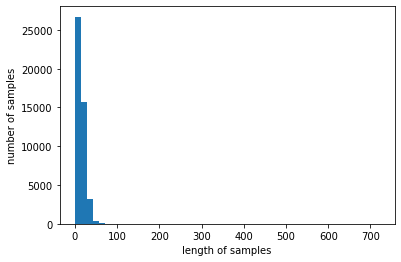

In [25]:
Train_data=Train_sequences
Test_data=Test_sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in Train_data))
print('메일의 평균 길이 : %f' % (sum(map(len, Train_data))/len(Train_data)))
plt.hist([len(s) for s in Train_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
max_len = 721
data_train_pad = pad_sequences(Train_data, maxlen = max_len)
data_test_pad = pad_sequences(Test_data, maxlen = max_len)
print("훈련 데이터의 크기 (shape):", data_train_pad.shape)
print("테스트 데이터의 크기 (shape):", data_test_pad.shape)
# Train_y_data : label

훈련 데이터의 크기 (shape): (46161, 721)
테스트 데이터의 크기 (shape): (65827, 721)


In [27]:
### rnn으로 신문분류하기

In [28]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length = max_len)) # 임베딩 벡터의 차원은 32   # (vocab_size, 32, input_length = max_len)
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(data_train_pad, Train_y_data, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
577/577 [==============================] - 104s 181ms/step - loss: 0.3469 - acc: 0.8280 - val_loss: 0.1043 - val_acc: 0.9814
Epoch 2/10
577/577 [==============================] - 103s 178ms/step - loss: 0.1564 - acc: 0.9393 - val_loss: 0.2179 - val_acc: 0.8881
Epoch 3/10
577/577 [==============================] - 108s 187ms/step - loss: 0.0943 - acc: 0.9655 - val_loss: 0.1795 - val_acc: 0.9226
Epoch 4/10
577/577 [==============================] - 103s 179ms/step - loss: 0.0499 - acc: 0.9841 - val_loss: 0.1397 - val_acc: 0.9421
Epoch 5/10
577/577 [==============================] - 103s 179ms/step - loss: 0.0296 - acc: 0.9911 - val_loss: 0.2106 - val_acc: 0.9233
Epoch 6/10
577/577 [==============================] - 103s 179ms/step - loss: 0.0562 - acc: 0.9794 - val_loss: 0.2455 - val_acc: 0.9131
Epoch 7/10
577/577 [==============================] - 104s 181ms/step - loss: 0.0209 - acc: 0.9935 - val_loss: 0.2746 - val_acc: 0.9106
Epoch 8/10
577/577 [============================

In [31]:
y_pred = model.predict(data_test_pad)

In [35]:
y_pred[0]

array([0.09295353], dtype=float32)

In [36]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(data_test_pad, y_test)[1]))    # ????

NameError: ignored

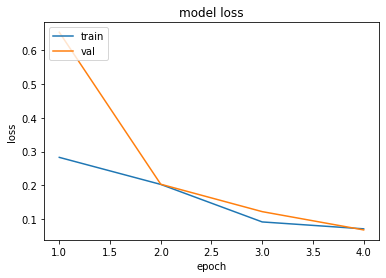

In [84]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()